Special thanks to Wei Hao Khoong for the amazing [kernel](https://www.kaggle.com/khoongweihao/resnet34-more-augmentations-mixup-tta-inference)

Please upvote the original notebook as well

In [1]:
!pip install image-classifiers

     |████████████████████████████████| 50 kB 1.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import random
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from pathlib import Path
import io
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from kaggle_datasets import KaggleDatasets
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from IPython.display import Audio


from classification_models.keras import Classifiers

tf.__version__

'2.2.0'

In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [4]:
# from https://github.com/qubvel/classification_models
seresnet34, preprocess_input = Classifiers.get('seresnet34')

In [5]:
cfg = {
    'parse_params': {
        'cut_time': 10,
    },
    'data_params': {
        'sample_time': 6, # assert 60 % sample_time == 0
        'spec_fmax': 24000.0,
        'spec_fmin': 40.0,
        'spec_mel': 224,
        'mel_power': 2,
        'img_shape': (224, 512)
    },
    'model_params': {
        'batchsize_per_tpu': 64,
        'iteration_per_epoch': 64,
        'epoch': 18,
        'arch': seresnet34,
        'arch_preprocess': preprocess_input,
        'freeze_to': 0,  # Freeze to backbone.layers[:freeze_to]. If None, all layers in the backbone will be freezed.
        'loss': {
            'fn': tfa.losses.SigmoidFocalCrossEntropy,
            'params': {},
        },
        'optim': {
            'fn': tfa.optimizers.RectifiedAdam,
            'params': {'lr': 1e-3, 'total_steps': 18*64, 'warmup_proportion': 0.3, 'min_lr': 1e-6},
        },
        'mixup': False
    }
}

In [6]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')]


In [7]:
strategy = tf.distribute.experimental.TPUStrategy(tpu)
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

TRAIN_TFREC = GCS_DS_PATH + "/tfrecords/train"
TEST_TFREC = GCS_DS_PATH + "/tfrecords/test"

In [8]:
CUT = cfg['parse_params']['cut_time']
SR = 48000     # all wave's sample rate may be 48k

TIME = cfg['data_params']['sample_time']

FMAX = cfg['data_params']['spec_fmax']
FMIN = cfg['data_params']['spec_fmin']
N_MEL = cfg['data_params']['spec_mel']

HEIGHT, WIDTH = cfg['data_params']['img_shape']

CLASS_N = 24

# Explore the tfrecords, Create dataset

In [9]:
raw_dataset = tf.data.TFRecordDataset([TRAIN_TFREC + '/00-148.tfrec'])
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

## parse tfrecords

In [10]:
feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'audio_wav': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label_info': tf.io.FixedLenFeature([], tf.string, default_value=''),
}
parse_dtype = {
    'audio_wav': tf.float32,
    'recording_id': tf.string,
    'species_id': tf.int32,
    'songtype_id': tf.int32,
    't_min': tf.float32,
    'f_min': tf.float32,
    't_max': tf.float32,
    'f_max':tf.float32,
    'is_tp': tf.int32
}

@tf.function
def _parse_function(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    label_info = tf.strings.split(sample['label_info'], sep='"')[1]
    labels = tf.strings.split(label_info, sep=';')
    
    @tf.function
    def _cut_audio(label):
        items = tf.strings.split(label, sep=',')
        spid = tf.squeeze(tf.strings.to_number(items[0], tf.int32))
        soid = tf.squeeze(tf.strings.to_number(items[1], tf.int32))
        tmin = tf.squeeze(tf.strings.to_number(items[2]))
        fmin = tf.squeeze(tf.strings.to_number(items[3]))
        tmax = tf.squeeze(tf.strings.to_number(items[4]))
        fmax = tf.squeeze(tf.strings.to_number(items[5]))
        tp = tf.squeeze(tf.strings.to_number(items[6], tf.int32))

        tmax_s = tmax * tf.cast(SR, tf.float32)
        tmin_s = tmin * tf.cast(SR, tf.float32)
        cut_s = tf.cast(CUT * SR, tf.float32)
        all_s = tf.cast(60 * SR, tf.float32)
        tsize_s = tmax_s - tmin_s
        cut_min = tf.cast(
            tf.maximum(0.0, 
                tf.minimum(tmin_s - (cut_s - tsize_s) / 2,
                           tf.minimum(tmax_s + (cut_s - tsize_s) / 2, all_s) - cut_s)
            ), tf.int32
        )
        cut_max = cut_min + CUT * SR
        
        _sample = {
            'audio_wav': tf.reshape(wav[cut_min:cut_max], [CUT*SR]),
            'recording_id': sample['recording_id'],
            'species_id': spid,
            'songtype_id': soid,
            't_min': tmin - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32),
            'f_min': fmin,
            't_max': tmax - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32),
            'f_max': fmax,
            'is_tp': tp
        }
        return _sample
    
    samples = tf.map_fn(_cut_audio, labels, dtype=parse_dtype)
    return samples

parsed_dataset = raw_dataset.map(_parse_function).unbatch()

In [11]:
@tf.function
def _cut_wav(x):
    # random cut in training
    cut_min = tf.random.uniform([], maxval=tf.minimum((CUT-TIME)*SR, tf.cast(x['t_max']*SR, tf.int32)), dtype=tf.int32)
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y
    
@tf.function
def _cut_wav_val(x):
    # center crop in validation
    cut_min = tf.minimum((CUT-TIME)*SR // 2, tf.cast((x['t_min'] + x['t_max']) / 2 * SR, tf.int32))
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y

In [12]:
@tf.function
def _filtTP(x):
    return x['is_tp'] == 1

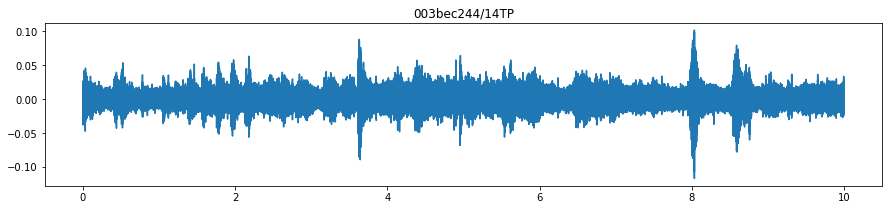

In [13]:
def show_wav(sample, ax):
    wav = sample["audio_wav"].numpy()
    rate = SR
    ax.plot(np.arange(len(wav)) / rate, wav)
    ax.set_title(
        sample["recording_id"].numpy().decode()
        + ("/%d" % sample["species_id"])
        + ("TP" if sample["is_tp"] else "FP"))

    return Audio((wav * 2**15).astype(np.int16), rate=rate)

fig, ax = plt.subplots(figsize=(15, 3))
show_wav(next(iter(parsed_dataset)), ax)

## create mel-spectrogram

In [14]:
@tf.function
def _wav_to_spec(x):
    mel_power = cfg['data_params']['mel_power']
    
    stfts = tf.signal.stft(x["audio_wav"], frame_length=2048, frame_step=512, fft_length=2048)
    spectrograms = tf.abs(stfts) ** mel_power

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = FMIN, FMAX, N_MEL
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, SR, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    y = {
        'audio_spec': tf.transpose(log_mel_spectrograms), # (num_mel_bins, frames)
    }
    y.update(x)
    return y

spec_dataset = parsed_dataset.filter(_filtTP).map(_cut_wav).map(_wav_to_spec)

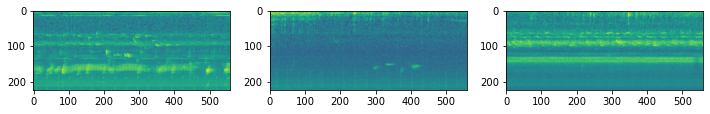

In [15]:
plt.figure(figsize=(12,5))
for i, s in enumerate(spec_dataset.take(3)):
    plt.subplot(1,3,i+1)
    plt.imshow(s['audio_spec'])
plt.show()

In [16]:
import librosa.display
import matplotlib.patches as patches

def show_spectrogram(sample, ax, showlabel=False):
    S_dB = sample["audio_spec"].numpy()
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=SR,
                             fmax=FMAX, fmin=FMIN, ax=ax, cmap='magma')
    ax.set(title=f'Mel-frequency spectrogram of {sample["recording_id"].numpy().decode()}')
    sid, fmin, fmax, tmin, tmax, istp = (
            sample["species_id"], sample["f_min"], sample["f_max"], sample["t_min"], sample["t_max"], sample["is_tp"])
    ec = '#00ff00' if istp == 1 else '#0000ff'
    ax.add_patch(
        patches.Rectangle(xy=(tmin, fmin), width=tmax-tmin, height=fmax-fmin, ec=ec, fill=False)
    )

    if showlabel:
        ax.text(tmin, fmax, 
        f"{sid.numpy().item()} {'tp' if istp == 1 else 'fp'}",
        horizontalalignment='left', verticalalignment='bottom', color=ec, fontsize=16)

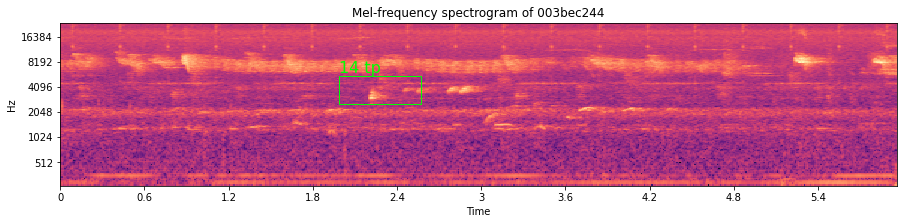

In [17]:
fig, ax = plt.subplots(figsize=(15,3))
show_spectrogram(next(iter(spec_dataset)), ax, showlabel=True)

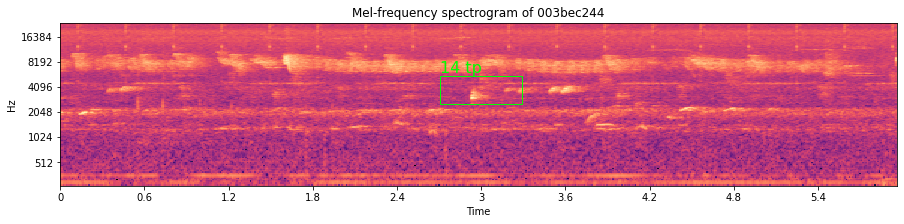

In [18]:
# in validation, annotations will come to the center
fig, ax = plt.subplots(figsize=(15,3))
show_spectrogram(next(iter(parsed_dataset.filter(_filtTP).map(_cut_wav_val).map(_wav_to_spec))), ax, showlabel=True)

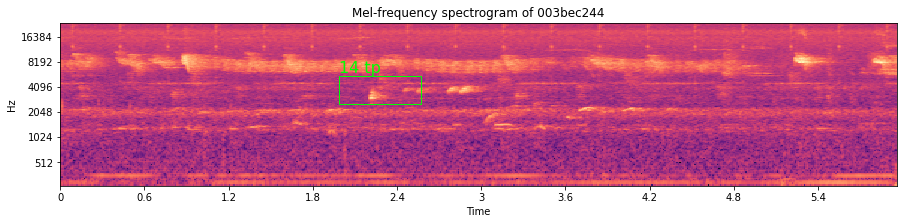

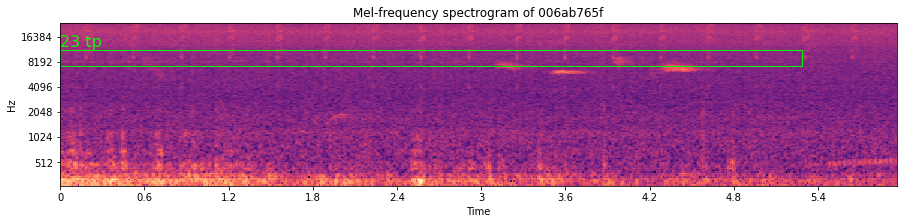

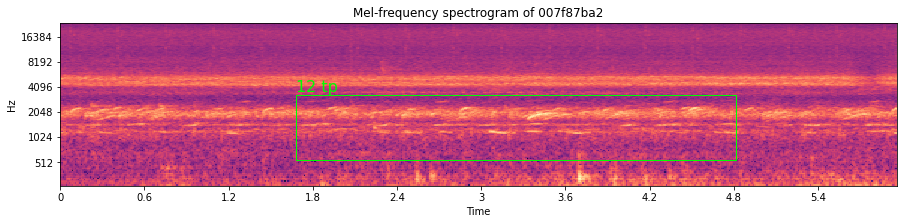

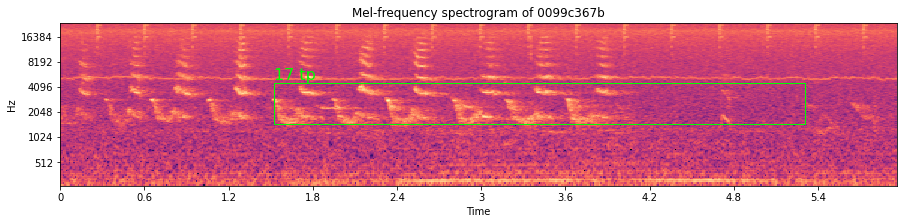

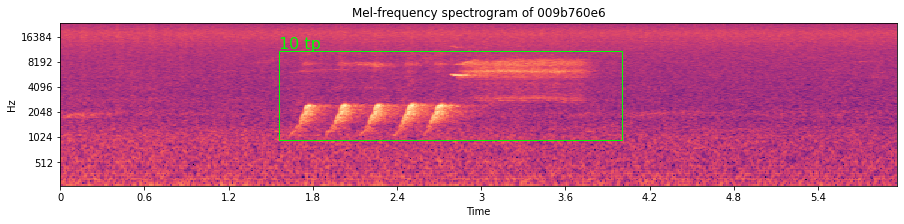

In [19]:
for sample in spec_dataset.take(5):
    fig, ax = plt.subplots(figsize=(15,3))
    show_spectrogram(sample, ax, showlabel=True)

## create labels

In [20]:
@tf.function
def _create_annot(x):
    targ = tf.one_hot(x["species_id"], CLASS_N, on_value=x["is_tp"], off_value=0)
    
    return {
        'input': x["audio_spec"],
        'target': tf.cast(targ, tf.float32)
    }

annot_dataset = spec_dataset.map(_create_annot)

## proprocessing and data augmentation

In training, I use

* gaussian noise
* random flip left & right (NEW)
* random brightness
* specaugment

In [21]:
@tf.function
def _preprocess_img(x, training=False, test=False):
    image = tf.expand_dims(x, axis=-1)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.image.per_image_standardization(image)
    
    @tf.function
    def _specaugment(image):
        ERASE_TIME = 50
        ERASE_MEL = 16
        image = tf.expand_dims(image, axis=0)
        xoff = tf.random.uniform([2], minval=ERASE_TIME//2, maxval=WIDTH-ERASE_TIME//2, dtype=tf.int32)
        xsize = tf.random.uniform([2], minval=ERASE_TIME//2, maxval=ERASE_TIME, dtype=tf.int32)
        yoff = tf.random.uniform([2], minval=ERASE_MEL//2, maxval=HEIGHT-ERASE_MEL//2, dtype=tf.int32)
        ysize = tf.random.uniform([2], minval=ERASE_MEL//2, maxval=ERASE_MEL, dtype=tf.int32)
        image = tfa.image.cutout(image, [HEIGHT, xsize[0]], offset=[HEIGHT//2, xoff[0]])
        image = tfa.image.cutout(image, [HEIGHT, xsize[1]], offset=[HEIGHT//2, xoff[1]])
        image = tfa.image.cutout(image, [ysize[0], WIDTH], offset=[yoff[0], WIDTH//2])
        image = tfa.image.cutout(image, [ysize[1], WIDTH], offset=[yoff[1], WIDTH//2])
        image = tf.squeeze(image, axis=0)
        return image
    
    if training:
        # gaussian
        gau = tf.keras.layers.GaussianNoise(0.3)
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: gau(image, training=True), lambda: image)
        # brightness
        image = tf.image.random_brightness(image, 0.2)
        # random left right flip (NEW)
        image = tf.image.random_flip_left_right(image)
        # specaugment
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment(image), lambda: image)
        
    if test:
        # Insert augmentations for TTA here
        #image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment(image), lambda: image)
        pass
        
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image)) * 255.0 # rescale to [0, 255]
    image = tf.image.grayscale_to_rgb(image)
    image = cfg['model_params']['arch_preprocess'](image)

    return image

@tf.function
def _preprocess(x):
    image = _preprocess_img(x['input'], training=True, test=False)
    return (image, x["target"])

@tf.function
def _preprocess_val(x):
    image = _preprocess_img(x['input'], training=False, test=False)
    return (image, x["target"])

@tf.function
def _preprocess_test(x):
    image = _preprocess_img(x['audio_spec'], training=False, test=True)
    return (image, x["recording_id"])

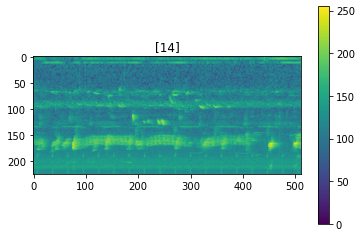

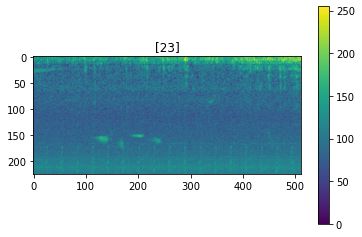

In [22]:
for inp, targ in annot_dataset.map(_preprocess).take(2):
    plt.imshow(inp.numpy()[:,:,0])
    t = targ.numpy()
    if t.sum() == 0:
        plt.title(f'FP')
    else:
        plt.title(f'{t.nonzero()[0]}')
    plt.colorbar()
    plt.show()

# Model

In [23]:
def create_model():
    with strategy.scope():
        #backbone = cfg['model_params']['arch'](include_top=False, weights='imagenet')
        backbone = cfg['model_params']['arch']((224, 224, 3), include_top=False, weights='imagenet')
        
        if cfg['model_params']['freeze_to'] is None:
            for layer in backbone.layers:
                layer.trainable = False
        else:
            for layer in backbone.layers[:cfg['model_params']['freeze_to']]:
                layer.trainable = False

        model = tf.keras.Sequential([
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(CLASS_N, bias_initializer=tf.keras.initializers.Constant(-2.))])
    return model

model = create_model()
model.summary()

86319104/86315168 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         21463669  
_________________________________________________________________
global_average_pooling2d_16  (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________

In [24]:
@tf.function
def _mixup(inp, targ):
    indice = tf.range(len(inp))
    indice = tf.random.shuffle(indice)
    sinp = tf.gather(inp, indice, axis=0)
    starg = tf.gather(targ, indice, axis=0)
    
    alpha = 0.2
    t = tf.compat.v1.distributions.Beta(alpha, alpha).sample([len(inp)])
    tx = tf.reshape(t, [-1, 1, 1, 1])
    ty = tf.reshape(t, [-1, 1])
    x = inp * tx + sinp * (1-tx)
    y = targ * ty + starg * (1-ty)
#     y = tf.minimum(targ + starg, 1.0) # for multi-label???
    return x, y

In [25]:
tfrecs = sorted(tf.io.gfile.glob(TRAIN_TFREC + '/*.tfrec'))
parsed_trainval = (tf.data.TFRecordDataset(tfrecs, num_parallel_reads=AUTOTUNE)
                    .map(_parse_function, num_parallel_calls=AUTOTUNE).unbatch()
                    .filter(_filtTP).enumerate())

# Stratified 5-Fold

In [26]:
indices = []
spid = []
recid = []

for i, sample in tqdm(parsed_trainval.prefetch(AUTOTUNE)):
    indices.append(i.numpy())
    spid.append(sample['species_id'].numpy())
    recid.append(sample['recording_id'].numpy().decode())

1216it [00:43, 28.10it/s]


In [27]:
table = pd.DataFrame({'indices': indices, 'species_id': spid, 'recording_id': recid})
table

,indices,species_id,recording_id
0,0,14,003bec244
1,1,12,2026bced7
2,2,21,422de4e4d
3,3,6,60a493ad4
4,4,13,8080b2283
...,...,...,...
1211,1211,3,807efd6bb
1212,1212,20,a6610076b
1213,1213,23,c91cae4aa
1214,1214,3,c91cae4aa


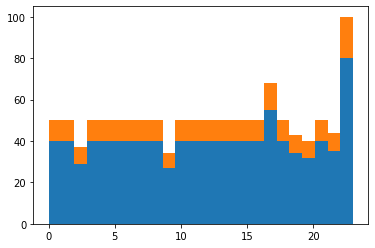

In [28]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
splits = list(skf.split(table.index, table.species_id))

plt.hist([table.loc[splits[0][0], 'species_id'], table.loc[splits[0][1], 'species_id']], bins=CLASS_N,stacked=True)
plt.show()

In [29]:
def create_idx_filter(indice):
    @tf.function
    def _filt(i, x):
        return tf.reduce_any(indice == i)
    return _filt

@tf.function
def _remove_idx(i, x):
    return x

# Other setup

In [30]:
def create_train_dataset(batchsize, train_idx):
    global parsed_trainval
    parsed_train = (parsed_trainval
                    .filter(create_idx_filter(train_idx))
                    .map(_remove_idx))
    
    dataset = (parsed_train.cache()
        .shuffle(len(train_idx))
        .repeat()
        .map(_cut_wav, num_parallel_calls=AUTOTUNE)
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess, num_parallel_calls=AUTOTUNE)
        .batch(batchsize))

    if cfg['model_params']['mixup']:
        dataset = (dataset.map(_mixup, num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE))
    else:
        dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_val_dataset(batchsize, val_idx):
    global parsed_trainval
    parsed_val = (parsed_trainval
                  .filter(create_idx_filter(val_idx))
                  .map(_remove_idx))

    vdataset = (parsed_val
        .map(_cut_wav_val, num_parallel_calls=AUTOTUNE)
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_val, num_parallel_calls=AUTOTUNE)
        .batch(8*strategy.num_replicas_in_sync)
        .cache())
    return vdataset

# Metrics

In [31]:
# from https://www.kaggle.com/carlthome/l-lrap-metric-for-tf-keras
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

# Testset and Inference function

In [32]:
def _parse_function_test(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    
    @tf.function
    def _cut_audio(i):
        _sample = {
            'audio_wav': tf.reshape(wav[i*SR*TIME:(i+1)*SR*TIME], [SR*TIME]),
            'recording_id': sample['recording_id']
        }
        return _sample

    return tf.map_fn(_cut_audio, tf.range(60//TIME), dtype={
        'audio_wav': tf.float32,
        'recording_id': tf.string
    })

def inference(model):
    tdataset = (tf.data.TFRecordDataset(tf.io.gfile.glob(TEST_TFREC + '/*.tfrec'), num_parallel_reads=AUTOTUNE)
        .map(_parse_function_test, num_parallel_calls=AUTOTUNE).unbatch()
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_test, num_parallel_calls=AUTOTUNE)
        .batch(128*(60//TIME)).prefetch(AUTOTUNE))
    
    rec_ids = []
    probs = []
    for inp, rec_id in tqdm(tdataset):
        with strategy.scope():
            pred = model.predict_on_batch(tf.reshape(inp, [-1, HEIGHT, WIDTH, 3]))
            prob = tf.sigmoid(pred)
            prob = tf.reduce_max(tf.reshape(prob, [-1, 60//TIME, CLASS_N]), axis=1)

        rec_id_stack = tf.reshape(rec_id, [-1, 60//TIME])
        for rec in rec_id.numpy():
            assert len(np.unique(rec)) == 1
        rec_ids.append(rec_id_stack.numpy()[:,0])
        probs.append(prob.numpy())
        
    crec_ids = np.concatenate(rec_ids)
    cprobs = np.concatenate(probs)
    
    sub = pd.DataFrame({
        'recording_id': list(map(lambda x: x.decode(), crec_ids.tolist())),
        **{f's{i}': cprobs[:,i] for i in range(CLASS_N)}
    })
    sub = sub.sort_values('recording_id')
    return sub

# Now start training!

In [33]:
def plot_history(history, name):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("loss")
    # plt.yscale('log')

    plt.subplot(1,2,2)
    plt.plot(history.history["lwlrap"])
    plt.plot(history.history["val_lwlrap"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("metric")

    plt.savefig(name)

In [34]:
def train_and_inference(splits, split_id):
    batchsize = cfg['model_params']['batchsize_per_tpu'] * strategy.num_replicas_in_sync
    print("batchsize", batchsize)
    loss_fn = cfg['model_params']['loss']['fn'](from_logits=True, **cfg['model_params']['loss']['params'])

    idx_train_tf = tf.constant(splits[split_id][0])
    idx_val_tf = tf.constant(splits[split_id][1])

    dataset = create_train_dataset(batchsize, idx_train_tf)
    vdataset = create_val_dataset(batchsize, idx_val_tf)
    
    optimizer = cfg['model_params']['optim']['fn'](**cfg['model_params']['optim']['params'])
    model = create_model()
    with strategy.scope():
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=[LWLRAP(CLASS_N)])
        
    history = model.fit(dataset,
                        steps_per_epoch=cfg['model_params']['iteration_per_epoch'],
                        epochs=cfg['model_params']['epoch'],
                        validation_data=vdataset,
                        callbacks=[
                            tf.keras.callbacks.ReduceLROnPlateau(
                                'val_lwlrap', patience=10
                            ),
                            tf.keras.callbacks.ModelCheckpoint(
                                filepath='model_best_%d.h5' % split_id,
                                save_weights_only=True,
                                monitor='val_lwlrap',
                                mode='max',
                                save_best_only=True),
                        ])
    plot_history(history, 'history_%d.png' % split_id)
    
    ### inference ###
    model.load_weights('model_best_%d.h5' % split_id)
    return inference(model), history

batchsize 512
Epoch 1/18
64/64 [==============================] - 95s 1s/step - lwlrap: 0.1638 - loss: 2.2366 - val_lwlrap: 0.1558 - val_loss: 0.7689 - lr: 0.0010
Epoch 2/18
64/64 [==============================] - 58s 914ms/step - lwlrap: 0.2211 - loss: 1.6735 - val_lwlrap: 0.2059 - val_loss: 0.7483 - lr: 0.0010
Epoch 3/18
64/64 [==============================] - 60s 939ms/step - lwlrap: 0.2717 - loss: 1.1037 - val_lwlrap: 0.2831 - val_loss: 0.7130 - lr: 0.0010
Epoch 4/18
64/64 [==============================] - 61s 948ms/step - lwlrap: 0.3470 - loss: 0.6924 - val_lwlrap: 0.4057 - val_loss: 0.5951 - lr: 0.0010
Epoch 5/18
64/64 [==============================] - 61s 954ms/step - lwlrap: 0.4974 - loss: 0.4721 - val_lwlrap: 0.6215 - val_loss: 0.3786 - lr: 0.0010
Epoch 6/18
64/64 [==============================] - 60s 933ms/step - lwlrap: 0.6794 - loss: 0.3201 - val_lwlrap: 0.7458 - val_loss: 0.3081 - lr: 0.0010
Epoch 7/18
64/64 [==============================] - 61s 950ms/step - lwlrap: 

16it [01:05,  4.09s/it]


batchsize 512
Epoch 1/18
64/64 [==============================] - 93s 1s/step - lwlrap: 0.1676 - loss: 2.2408 - val_lwlrap: 0.1635 - val_loss: 0.7562 - lr: 0.0010
Epoch 2/18
64/64 [==============================] - 60s 934ms/step - lwlrap: 0.2166 - loss: 1.6596 - val_lwlrap: 0.2658 - val_loss: 0.6033 - lr: 0.0010
Epoch 3/18
64/64 [==============================] - 62s 968ms/step - lwlrap: 0.2697 - loss: 1.0530 - val_lwlrap: 0.3462 - val_loss: 0.6601 - lr: 0.0010
Epoch 4/18
64/64 [==============================] - 63s 984ms/step - lwlrap: 0.3460 - loss: 0.6537 - val_lwlrap: 0.4873 - val_loss: 0.5040 - lr: 0.0010
Epoch 5/18
64/64 [==============================] - 63s 980ms/step - lwlrap: 0.4943 - loss: 0.4679 - val_lwlrap: 0.7178 - val_loss: 0.4594 - lr: 0.0010
Epoch 6/18
64/64 [==============================] - 62s 976ms/step - lwlrap: 0.6774 - loss: 0.3357 - val_lwlrap: 0.7824 - val_loss: 0.2102 - lr: 0.0010
Epoch 7/18
64/64 [==============================] - 63s 983ms/step - lwlrap: 

16it [00:52,  3.31s/it]


batchsize 512
Epoch 1/18
64/64 [==============================] - 93s 1s/step - lwlrap: 0.1647 - loss: 2.2770 - val_lwlrap: 0.1844 - val_loss: 0.7547 - lr: 0.0010
Epoch 2/18
64/64 [==============================] - 57s 892ms/step - lwlrap: 0.2168 - loss: 1.6856 - val_lwlrap: 0.2577 - val_loss: 0.5946 - lr: 0.0010
Epoch 3/18
64/64 [==============================] - 59s 925ms/step - lwlrap: 0.2714 - loss: 1.0670 - val_lwlrap: 0.3710 - val_loss: 0.7075 - lr: 0.0010
Epoch 4/18
64/64 [==============================] - 59s 927ms/step - lwlrap: 0.3453 - loss: 0.6394 - val_lwlrap: 0.5622 - val_loss: 0.9676 - lr: 0.0010
Epoch 5/18
64/64 [==============================] - 59s 921ms/step - lwlrap: 0.5023 - loss: 0.4514 - val_lwlrap: 0.6991 - val_loss: 0.3661 - lr: 0.0010
Epoch 6/18
64/64 [==============================] - 59s 929ms/step - lwlrap: 0.6788 - loss: 0.3210 - val_lwlrap: 0.7897 - val_loss: 0.2951 - lr: 0.0010
Epoch 7/18
64/64 [==============================] - 59s 914ms/step - lwlrap: 

16it [00:58,  3.68s/it]


batchsize 512
Epoch 1/18
64/64 [==============================] - 97s 2s/step - lwlrap: 0.1684 - loss: 2.2529 - val_lwlrap: 0.1868 - val_loss: 0.7688 - lr: 0.0010
Epoch 2/18
64/64 [==============================] - 61s 952ms/step - lwlrap: 0.2175 - loss: 1.6800 - val_lwlrap: 0.2472 - val_loss: 0.6262 - lr: 0.0010
Epoch 3/18
64/64 [==============================] - 64s 1s/step - lwlrap: 0.2721 - loss: 1.0707 - val_lwlrap: 0.2958 - val_loss: 0.6369 - lr: 0.0010
Epoch 4/18
64/64 [==============================] - 64s 993ms/step - lwlrap: 0.3458 - loss: 0.6736 - val_lwlrap: 0.4330 - val_loss: 0.5295 - lr: 0.0010
Epoch 5/18
64/64 [==============================] - 63s 990ms/step - lwlrap: 0.4925 - loss: 0.4650 - val_lwlrap: 0.6580 - val_loss: 0.3214 - lr: 0.0010
Epoch 6/18
64/64 [==============================] - 64s 996ms/step - lwlrap: 0.6677 - loss: 0.3365 - val_lwlrap: 0.7389 - val_loss: 0.2819 - lr: 0.0010
Epoch 7/18
64/64 [==============================] - 64s 998ms/step - lwlrap: 0.7

16it [00:56,  3.50s/it]


batchsize 512
Epoch 1/18
64/64 [==============================] - 94s 1s/step - lwlrap: 0.1699 - loss: 2.2302 - val_lwlrap: 0.2070 - val_loss: 0.7538 - lr: 0.0010
Epoch 2/18
64/64 [==============================] - 59s 918ms/step - lwlrap: 0.2222 - loss: 1.6483 - val_lwlrap: 0.2156 - val_loss: 0.6445 - lr: 0.0010
Epoch 3/18
64/64 [==============================] - 61s 957ms/step - lwlrap: 0.2673 - loss: 1.0223 - val_lwlrap: 0.3535 - val_loss: 0.5996 - lr: 0.0010
Epoch 4/18
64/64 [==============================] - 61s 961ms/step - lwlrap: 0.3286 - loss: 0.6315 - val_lwlrap: 0.5630 - val_loss: 0.4252 - lr: 0.0010
Epoch 5/18
64/64 [==============================] - 62s 969ms/step - lwlrap: 0.4762 - loss: 0.4484 - val_lwlrap: 0.6603 - val_loss: 0.4625 - lr: 0.0010
Epoch 6/18
64/64 [==============================] - 61s 955ms/step - lwlrap: 0.6569 - loss: 0.3297 - val_lwlrap: 0.7514 - val_loss: 0.2385 - lr: 0.0010
Epoch 7/18
64/64 [==============================] - 61s 958ms/step - lwlrap: 

16it [00:54,  3.43s/it]


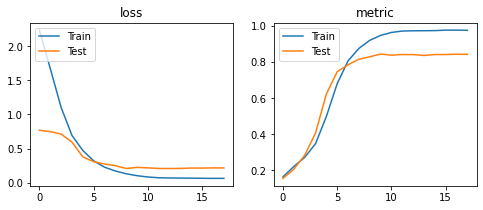

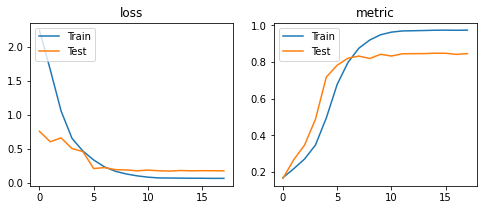

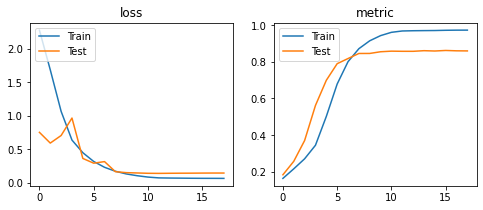

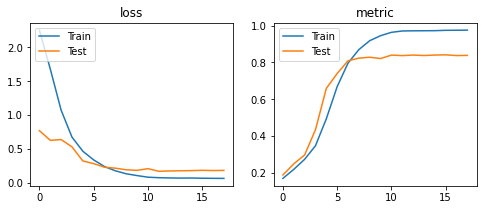

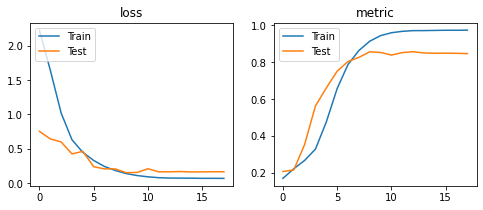

In [35]:
# train and inference
# sub, _ = train_and_inference(splits, 0)

# N-fold ensemble
sub = sum(
    map(
        lambda i: train_and_inference(splits, i)[0].set_index('recording_id'),
        range(len(splits))
    )
).reset_index()

In [36]:
sub.describe()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
count,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,...,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,0.866510,0.762504,0.767146,1.619787,0.643935,0.999119,0.667747,1.289585,0.764892,0.903880,...,0.904190,1.047816,0.945301,0.771516,0.883269,0.591229,0.843457,0.742431,0.714885,1.131659
std,0.625785,0.408282,0.597369,0.580639,0.172037,0.594838,0.262399,0.707613,0.387017,0.263515,...,0.706732,0.957540,0.722488,0.455150,0.442400,0.202573,0.363156,0.215618,0.430155,0.777606
min,0.426231,0.367355,0.409669,0.442223,0.353221,0.427274,0.367429,0.391843,0.415339,0.454481,...,0.390970,0.388538,0.436587,0.338322,0.416177,0.328540,0.448256,0.413636,0.377075,0.413441
25%,0.615434,0.577338,0.567068,1.166940,0.573152,0.649047,0.548158,0.780476,0.632476,0.741625,...,0.623801,0.594566,0.623459,0.563368,0.641646,0.531403,0.632299,0.650619,0.567823,0.689220
50%,0.681750,0.637179,0.621605,1.534782,0.620486,0.781823,0.600862,1.032619,0.674621,0.847680,...,0.701232,0.685039,0.709286,0.638654,0.719599,0.567081,0.748212,0.698938,0.627360,0.877688
75%,0.799265,0.741525,0.715024,2.014289,0.676214,1.092414,0.702527,1.539554,0.741638,1.002918,...,0.820838,0.847816,0.893410,0.795919,0.918080,0.612333,0.928148,0.764890,0.729056,1.207871
max,4.258039,4.040852,4.669065,3.622874,3.518359,4.219889,4.530659,3.985556,4.626384,4.174304,...,4.805019,4.833127,4.780081,4.828758,4.252956,4.773023,4.780379,3.206228,4.870560,4.905140


In [37]:
sub.to_csv("submission.csv", index=False)